# Dataset statistics

Please note that this notebook does not contain any comments or context on the statistics calculated or plots shown. For understanding the context of any of the results, please see the thesis where they are discussed in detail.

## Setup

##### Libraries

In [1]:
import shutil
import pandas as pd

import geopandas
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

%load_ext autoreload
%autoreload 2
import utils, plots

##### Data

In [2]:
proposal_folder = "../24212003_requirements_for_artificial_intelligence/"

feedbacks = pd.read_csv(f"{proposal_folder}patched_feedbacks.csv")
attachments = pd.read_csv(f"{proposal_folder}attachments.csv")

feedbacks = pd.merge(feedbacks, attachments, how="left")
feedbacks["filename"] = proposal_folder + feedbacks["filename"]
feedbacks["n_pages"] = feedbacks["filename"].map(utils.pdf_page_count)
feedbacks["is_eu"] = feedbacks["country"].isin(utils.EU_COUNTRIES)

feedbacks[["id", "country", "is_eu", "user_type"]].head(n=3)

,id,country,is_eu,user_type
0,2665651,BEL,True,ngo
1,2665650,AUT,True,ngo
2,2665649,DEU,True,ngo


In [3]:
by_country = utils.by_country(feedbacks)
by_country.head(3)

,country,country_name,2021_pop,2021_gdp,n_responses,is_eu,gdp_per_cap,responses_per_ten_million
0,BEL,Belgium,11587882.0,5.998790e+11,82,True,51767.788572,70.763579
1,DEU,Germany,83129285.0,4.223116e+12,54,True,50801.786711,6.495906
2,FRA,France,67499343.0,2.937473e+12,30,True,43518.538513,4.444488


In [4]:
survey = pd.read_csv(
    "../7639546_requirements_for_artificial_intelligence/feedbacks.csv"
)
survey_by_country = utils.by_country(survey)
survey_by_country.head(3)

,country,country_name,2021_pop,2021_gdp,n_responses,is_eu,gdp_per_cap,responses_per_ten_million
0,BEL,Belgium,11587882.0,5.998790e+11,131,True,51767.788572,113.049132
1,DEU,Germany,83129285.0,4.223116e+12,120,True,50801.786711,14.435346
2,FRA,France,67499343.0,2.937473e+12,71,True,43518.538513,10.518621


In [5]:
feedbacks["interest_type"] = feedbacks["user_type"].map(utils.interest_type_map)
feedbacks["user_type_name"] = feedbacks["user_type"].map(utils.user_type_map)
feedbacks[["user_type", "user_type_name", "interest_type"]].drop_duplicates().head()

,user_type,user_type_name,interest_type
0,ngo,NGO,public
3,academic_research_institution,Academia,academia
4,company,Company,corporate
6,business_association,Business Association,corporate
19,eu_citizen,EU Citizen,citizen


## General Statistics

In [6]:
import json
import requests

url = "https://ec.europa.eu/info/law/better-regulation/brpapi/groupInitiatives/12527"
com_ado = json.loads(requests.get(url).text)["publications"][-1]
print(pd.to_datetime(com_ado["adoptionDate"]), pd.to_datetime(com_ado["endDate"]))

2021-04-21 00:00:00 2021-08-06 23:59:59


In [7]:
unpatched_feedbacks = pd.read_csv(
    "../24212003_requirements_for_artificial_intelligence/feedbacks.csv"
)
unpatched_feedbacks = pd.merge(unpatched_feedbacks, attachments, how="left")
unpatched_feedbacks["filename"] = proposal_folder + unpatched_feedbacks["filename"]
unpatched_feedbacks["n_pages"] = unpatched_feedbacks["filename"].map(
    utils.pdf_page_count
)

utils.pprint(
    "Unpatched submissions:",
    len(unpatched_feedbacks),
    "Unpatched attachments:",
    len(unpatched_feedbacks.query("filename.notnull()")),
    "Unp. total pages (w/o 2596917):",
    unpatched_feedbacks.query("id != 2596917")["n_pages"].sum(),
)

Unpatched submissions:             304
Unpatched attachments:             259
Unp. total pages (w/o 2596917):   2298


In [8]:
utils.pprint(
    "Submissions:",
    len(feedbacks),
    "Attachments:",
    len(feedbacks.query("filename.notnull()")),
    "Total pages:",
    feedbacks["n_pages"].sum(),
)

Submissions:    299
Attachments:    255
Total pages:   2282


In [9]:
utils.pprint(
    "Countries:",
    len(feedbacks["country"].unique()),
    "EU countries:",
    len(feedbacks.query("is_eu")["country"].unique()),
)

Countries:      25
EU countries:   19


In [10]:
utils.pprint(
    "Interest types:",
    feedbacks["user_type_name"].unique().tolist(),
    "Citizens:",
    len(feedbacks.query("user_type == 'eu_citizen'")),
    "Cit. countries:",
    len(feedbacks.query("user_type == 'eu_citizen'")["country"].unique()),
)

Interest types:   ['NGO', 'Academia', 'Company', 'Business Association', 'EU Citizen', 'Trade Union', 'Consumer Organisation', 'Standardizing Body', 'Public Authority']
Citizens:         13
Cit. countries:    8


## Biases

#### Per-capita GDP

In [11]:
gdp_df = by_country.query("n_responses > 0 and country_name != 'Belgium'")

print("All countries of origin (excluding Belgium)")
utils.spearman_test(gdp_df, "gdp_per_cap", "responses_per_ten_million")

print("\nEU only (excluding Belgium)")
utils.spearman_test(gdp_df.query("is_eu"), "gdp_per_cap", "responses_per_ten_million")

print("\nWhitepaper survey for comparison - EU only (excl. Belgium)")
utils.spearman_test(
    survey_by_country.query("is_eu and n_responses > 0"),
    "gdp_per_cap",
    "responses_per_ten_million",
)

All countries of origin (excluding Belgium)
ρ=0.47   p=0.019   n=24

EU only (excluding Belgium)
ρ=0.53   p=0.025   n=18

Whitepaper survey for comparison - EU only (excl. Belgium)
ρ=0.81   p=3.39e-06   n=23


In [12]:
gdp_df = by_country.query("n_responses > 0")

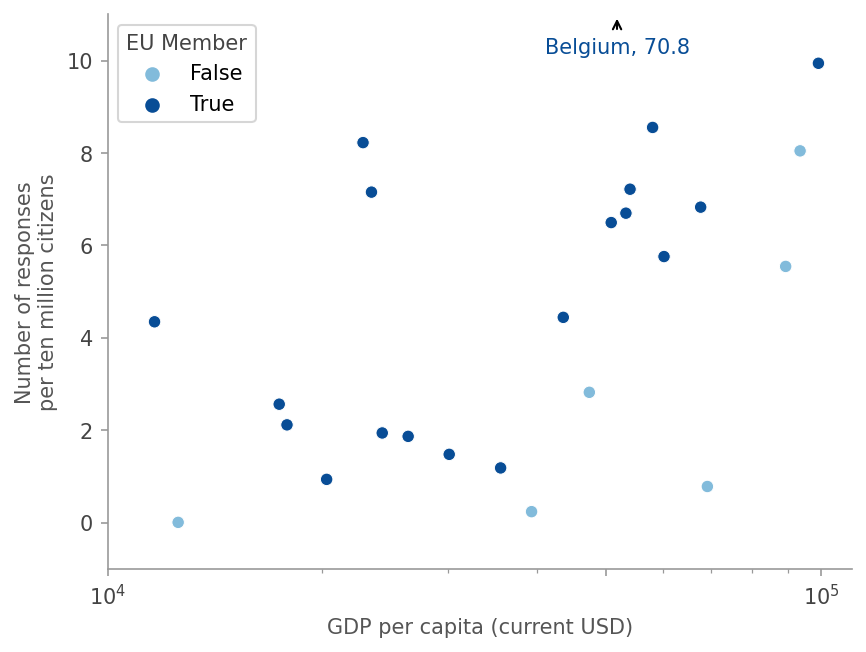

In [13]:
fig, ax = plots.plot_responses_gdp_scatter(gdp_df)

fig.savefig("figures/dataset_biases_gdp.pdf", bbox_inches="tight")

'../../masters_thesis/figures/dataset_biases_gdp_2.pdf'

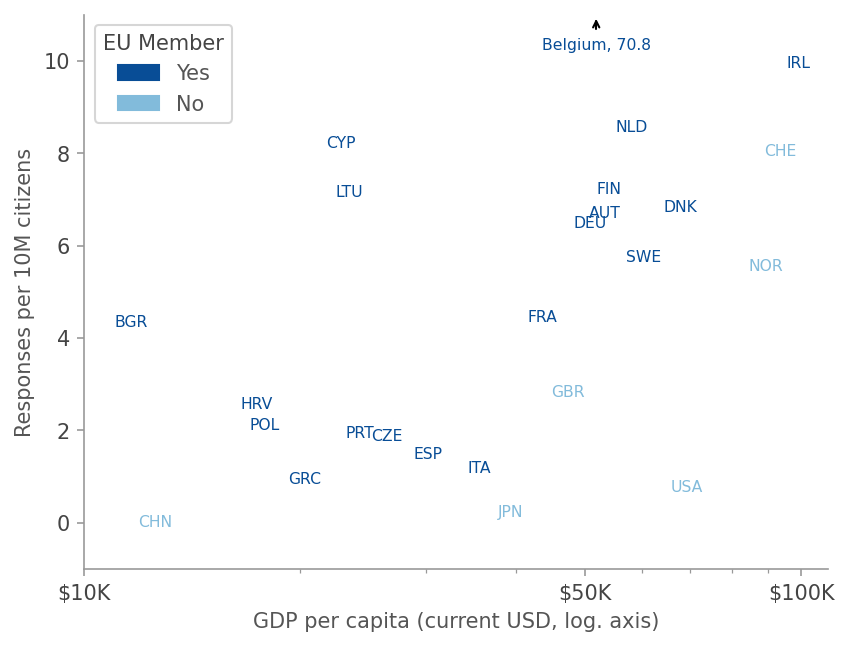

In [14]:
fig, _ = plots.plot_responses_gdp(gdp_df)

fig.savefig("figures/dataset_biases_gdp_2.pdf", bbox_inches="tight")
shutil.copy("figures/dataset_biases_gdp_2.pdf", "../../masters_thesis/figures/")

#### Geographic/historic

##### Country of Origin

In [15]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
countries = pd.merge(world, by_country, left_on="iso_a3", right_on="country")

countries = countries.sort_values("n_responses", ascending=True)
europe = utils._get_europe(countries).copy()
threshold = utils._get_threshold(countries)

In [16]:
utils.pprint(
    f"n={len(europe[threshold:])}:",
    europe[threshold:]["name"].unique(),
    f"Share of all feedbacks:",
    europe[threshold:]["n_responses"].sum() / by_country["n_responses"].sum(),
    f"Share of European feedbacks:",
    europe[threshold:]["n_responses"].sum() / europe["n_responses"].sum(),
    f"Share of EU feedbacks:",
    europe[threshold:]["n_responses"].sum()
    / by_country.query("is_eu")["n_responses"].sum(),
    f"Belgium's share alone:",
    europe.iloc[-1]["n_responses"].sum()
    / by_country.query("is_eu")["n_responses"].sum(),
)

n=3:                           ['France' 'Germany' 'Belgium']
Share of all feedbacks:        0.555
Share of European feedbacks:   0.617
Share of EU feedbacks:         0.692
Belgium's share alone:         0.342


'../../masters_thesis/figures/dataset_biases_countries.pdf'

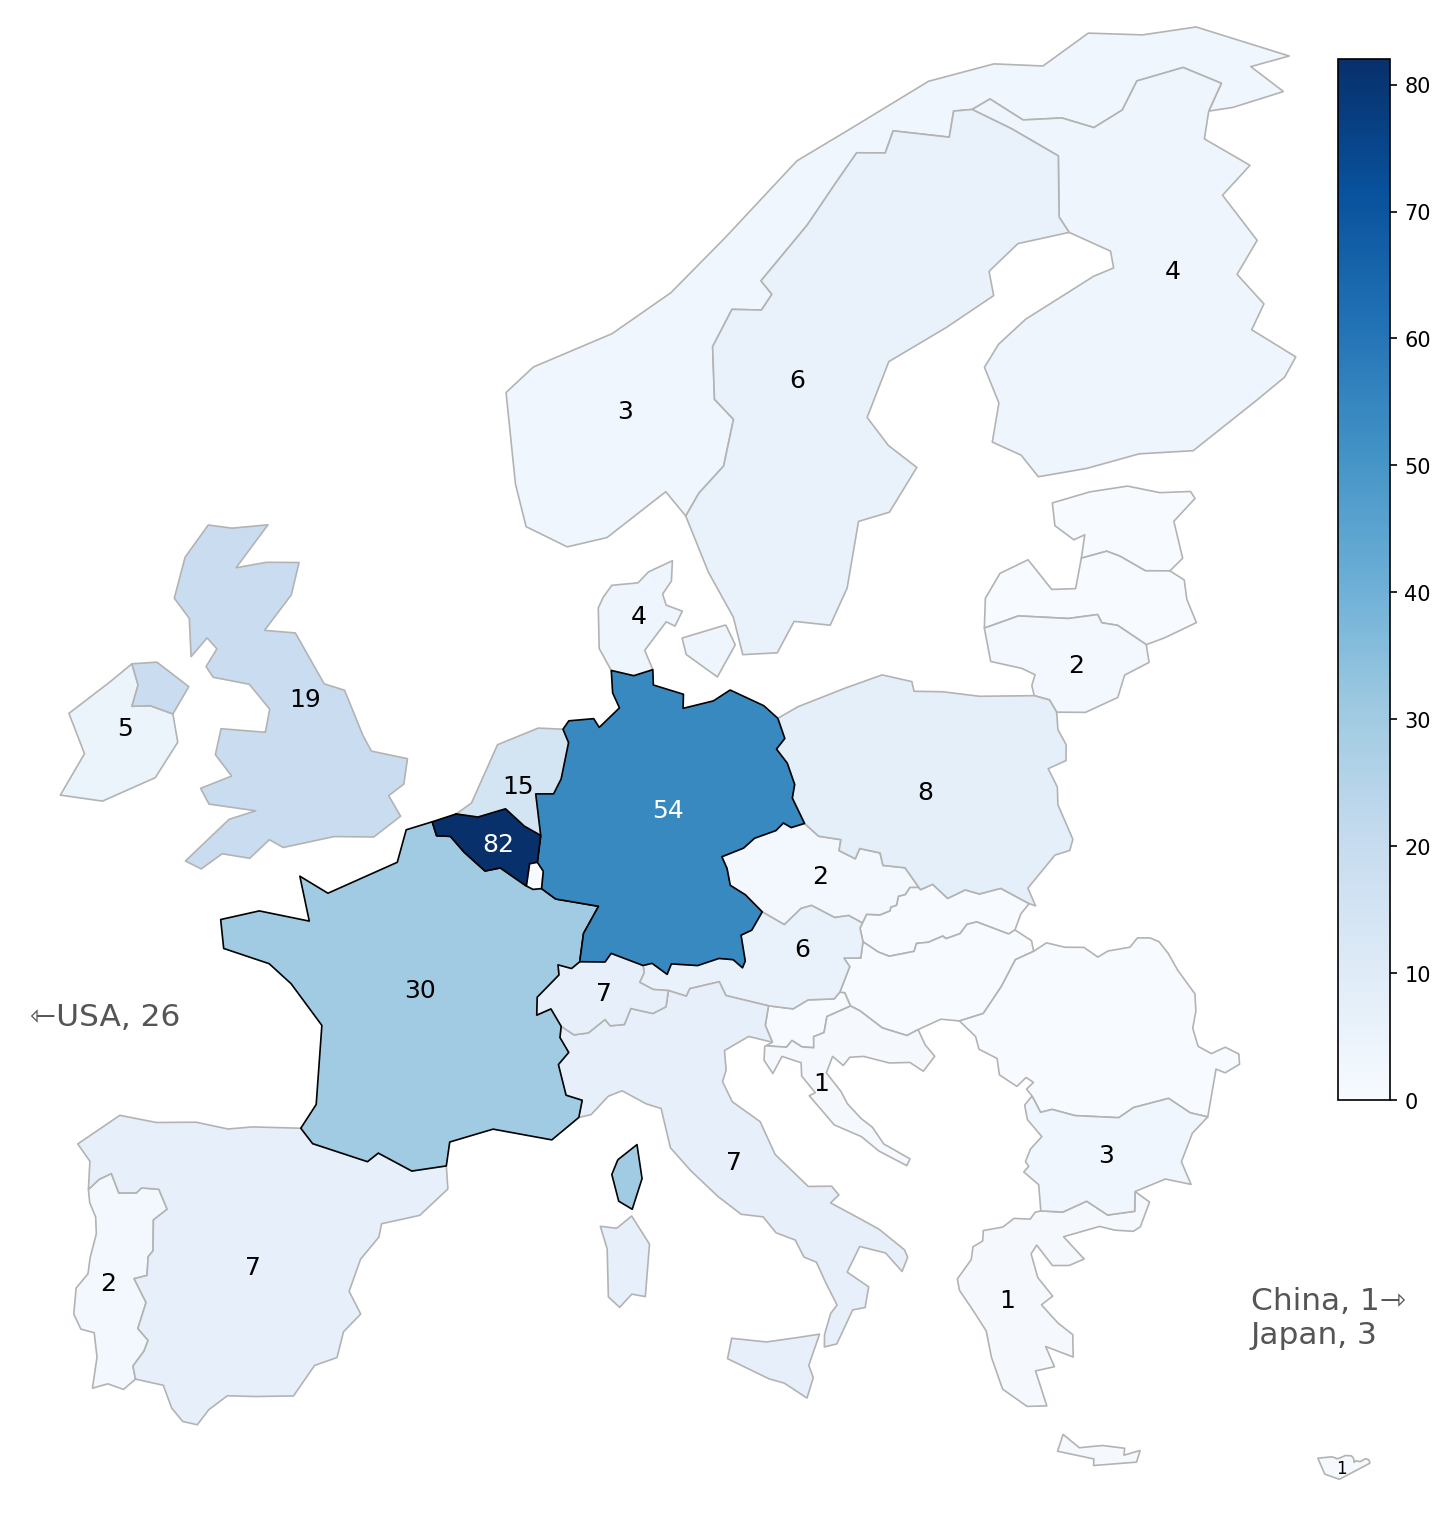

In [17]:
fig, ax = plots.map_responses(countries)

fig.savefig("figures/dataset_biases_countries.pdf", bbox_inches="tight")
shutil.copy("figures/dataset_biases_countries.pdf", "../../masters_thesis/figures/")

In [18]:
by_country["rel_responses"] = (
    by_country["n_responses"] / by_country["n_responses"].sum()
)
survey_by_country["rel_responses"] = (
    survey_by_country["n_responses"] / survey_by_country["n_responses"].sum()
)


def cum_rel(df):
    return utils.hstack(
        df[["country_name", "n_responses"]],
        df["rel_responses"],
        df["rel_responses"].cumsum().to_frame("rel_cum_sum"),
    ).head(10)


cum_rel(by_country)

,country_name,n_responses,rel_responses,rel_cum_sum
0,Belgium,82,0.274247,0.274247
1,Germany,54,0.180602,0.454849
2,France,30,0.100334,0.555184
3,United States,26,0.086957,0.642140
4,United Kingdom,19,0.063545,0.705686
5,Netherlands,15,0.050167,0.755853
6,Poland,8,0.026756,0.782609
7,Italy,7,0.023411,0.806020
8,Spain,7,0.023411,0.829431
9,Switzerland,7,0.023411,0.852843


In [19]:
cum_rel(survey_by_country)

,country_name,n_responses,rel_responses,rel_cum_sum
0,Belgium,131,0.173280,0.173280
1,Germany,120,0.158730,0.332011
2,France,71,0.093915,0.425926
3,Spain,61,0.080688,0.506614
4,United States,55,0.072751,0.579365
5,United Kingdom,52,0.068783,0.648148
6,Netherlands,43,0.056878,0.705026
7,Italy,37,0.048942,0.753968
8,Sweden,24,0.031746,0.785714
9,Finland,19,0.025132,0.810847


##### Country of Origin - Responses per ten million

'../../masters_thesis/figures/dataset_biases_countries_2.pdf'

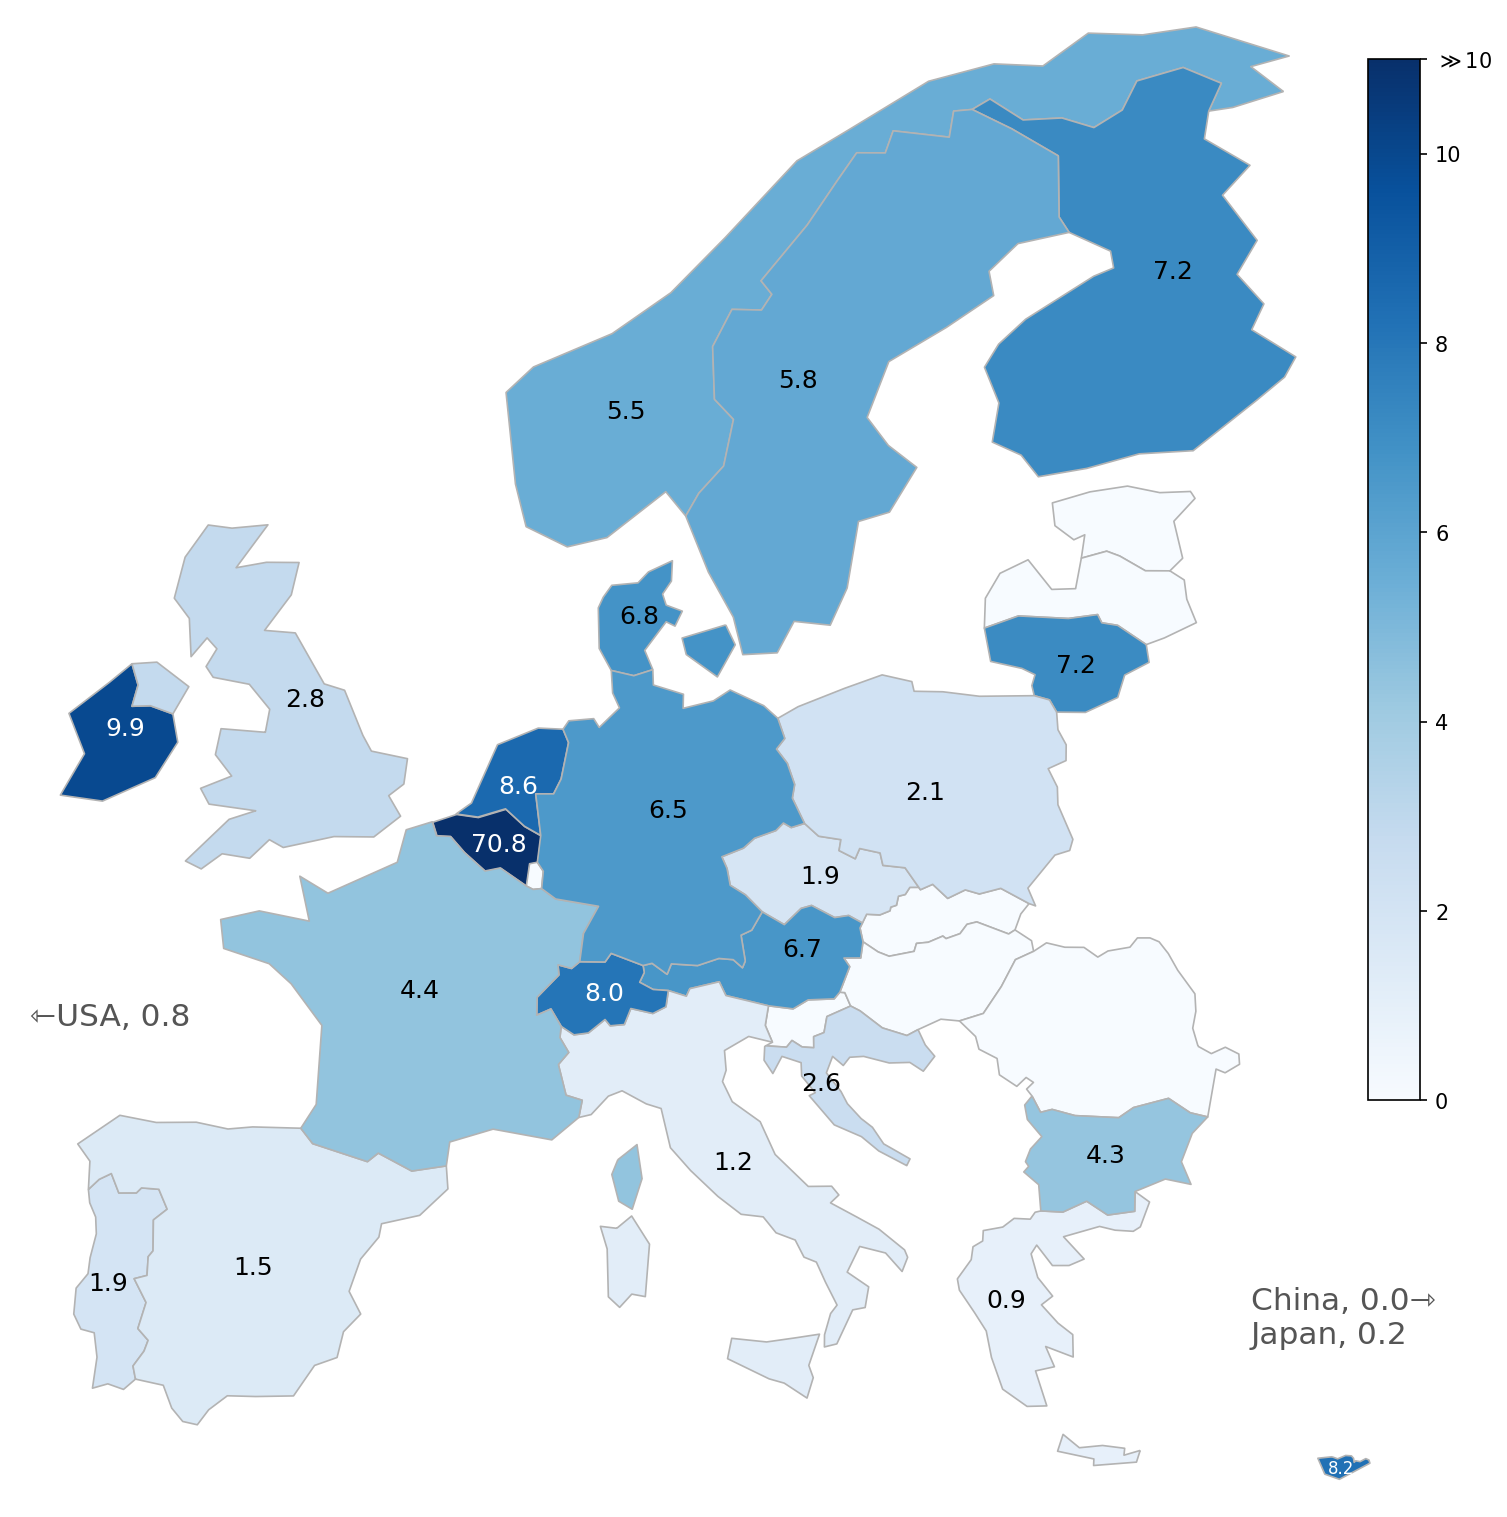

In [20]:
fig, _ = plots.map_relative_responses(countries)

fig.savefig("figures/dataset_biases_countries_2.pdf", bbox_inches="tight")
shutil.copy("figures/dataset_biases_countries_2.pdf", "../../masters_thesis/figures/")

##### Statistical testing

In [21]:
by_country["post_socialist"] = by_country["country"].isin(utils.EU_POST_SOCIALIST)
by_country["is_southern"] = by_country["country"].isin(utils.EU_SOUTH)
by_country["is_young"] = by_country["country"].isin(utils.EU_YOUNG)
by_country["south_eastern"] = by_country["country"].isin(
    set(utils.EU_SOUTH) | set(utils.EU_YOUNG)
)
geo_df = by_country.query("is_eu and country != 'BEL'").copy()

In [22]:
utils.mannwhitneyu_test(
    geo_df, "is_southern", "responses_per_ten_million", alternative="greater"
)

U=103.5   p=0.109   n=26


In [23]:
utils.mannwhitneyu_test(
    geo_df, "is_young", "responses_per_ten_million", alternative="greater"
)

U=125.5   p=0.018   n=26


In [24]:
utils.mannwhitneyu_test(
    geo_df, "post_socialist", "responses_per_ten_million", alternative="greater"
)

U=125.0   p=0.013   n=26


In [25]:
utils.mannwhitneyu_test(
    geo_df, "south_eastern", "responses_per_ten_million", alternative="greater"
)

U=128.5   p=0.002   n=26


#### Interest groups

##### Number of submissions

In [26]:
utils.hstack(
    feedbacks["user_type"].value_counts().to_frame("absolute"),
    feedbacks["user_type"].value_counts(normalize=True).to_frame("relative"),
)

,absolute,relative
company,87,0.290970
business_association,79,0.264214
ngo,63,0.210702
academic_research_institution,24,0.080268
trade_union,14,0.046823
eu_citizen,13,0.043478
public_authority,11,0.036789
consumer_organisation,5,0.016722
standardizing_body,3,0.010033


'../../masters_thesis/figures/dataset_biases_interest_groups.pdf'

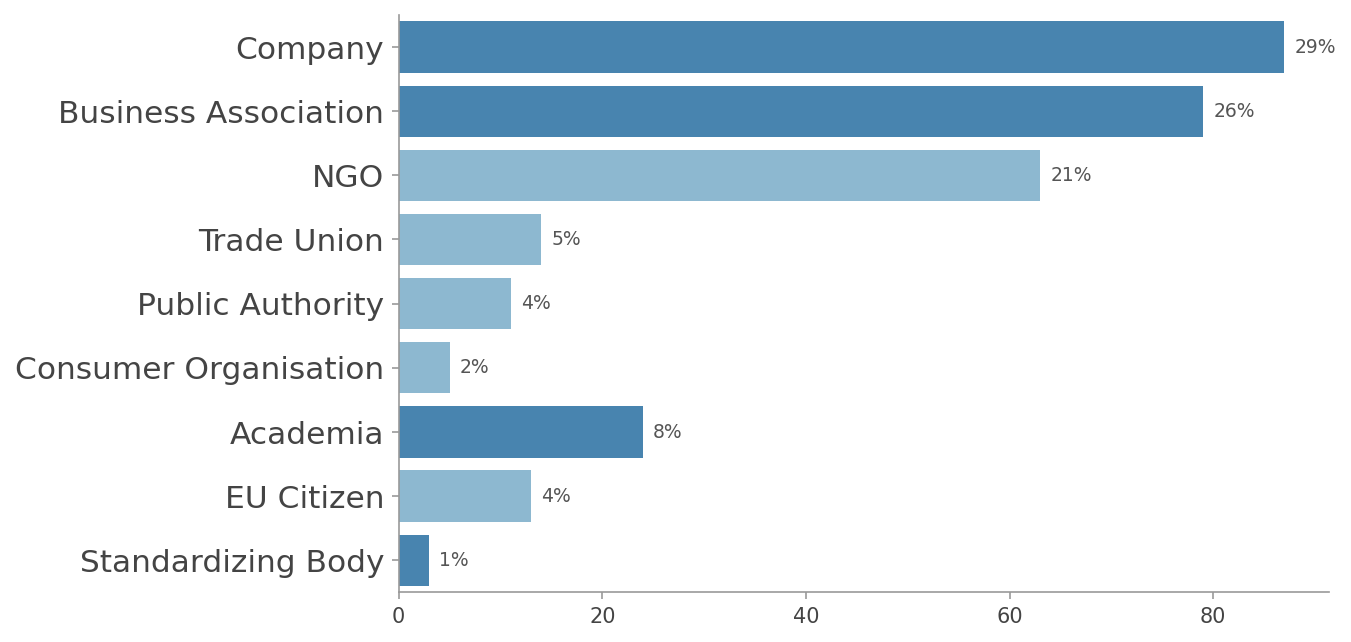

In [27]:
fig, _ = plots.dataset_interest_groups(feedbacks)

fig.savefig("figures/dataset_biases_interest_groups.pdf", bbox_inches="tight")
shutil.copy(
    "figures/dataset_biases_interest_groups.pdf", "../../masters_thesis/figures/"
)

In [28]:
grouped = feedbacks.groupby("interest_type")["company_size"]
df = utils.hstack(
    grouped.value_counts().to_frame("absolute"),
    grouped.value_counts(normalize=True).to_frame("relative"),
).reset_index()
df["company_size"] = pd.Categorical(
    df["company_size"], categories=["large", "medium", "small", "micro"], ordered=True
)
df.set_index(["interest_type", "company_size"]).sort_index()

absolute  relative
interest_type      company_size                    
academia           large                4  0.166667
                   medium               5  0.208333
                   small                7  0.291667
                   micro                8  0.333333
corporate          large               74  0.445783
                   medium              32  0.192771
                   small               33  0.198795
                   micro               27  0.162651
public             large               18  0.193548
                   medium              16  0.172043
                   small               29  0.311828
                   micro               30  0.322581
standardizing_body large                2  0.666667
                   medium               1  0.333333

##### Attachments

In [29]:
feedbacks["filename"].agg(lambda s: s.notnull().mean()).round(3)

0.853

In [30]:
has_att = feedbacks.groupby("user_type")["filename"].agg(lambda s: s.notnull().mean())
has_att = has_att.to_frame("has_attachment")
has_att.index = has_att.index.map(utils.user_type_map)
has_att.loc[utils.user_type_order]

,has_attachment
user_type,
Company,0.873563
Business Association,0.911392
NGO,0.825397
Trade Union,0.928571
Public Authority,0.818182
Consumer Organisation,0.600000
Academia,0.833333
EU Citizen,0.538462
Standardizing Body,1.000000


'../../masters_thesis/figures/dataset_biases_interest_groups_pages.pdf'

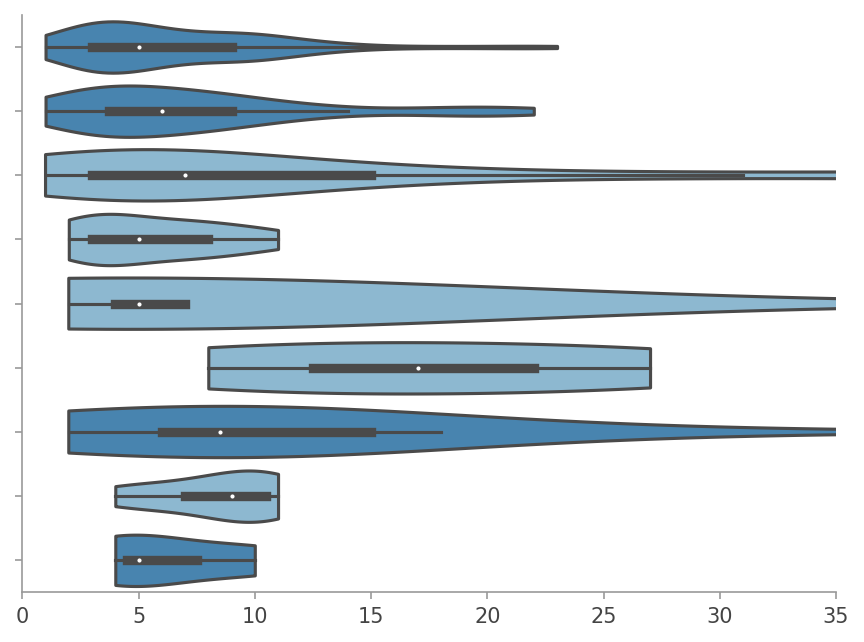

In [31]:
fig, _ = plots.interest_group_attachment_lengths(feedbacks)

fig.savefig("figures/dataset_biases_interest_groups_pages.pdf", bbox_inches="tight")
shutil.copy(
    "figures/dataset_biases_interest_groups_pages.pdf", "../../masters_thesis/figures/"
)

In [32]:
n_p = feedbacks.query("filename.notnull()").groupby("user_type")["n_pages"].median()
n_p = n_p.to_frame("median_pages")
n_p.index = n_p.index.map(utils.user_type_map)
n_p.loc[utils.user_type_order]

,median_pages
user_type,
Company,5.0
Business Association,6.0
NGO,7.0
Trade Union,5.0
Public Authority,5.0
Consumer Organisation,17.0
Academia,8.5
EU Citizen,9.0
Standardizing Body,5.0


In [33]:
feedbacks.query("n_pages > 50")[
    ["id", "country", "user_type", "organization", "n_pages"]
].sort_values("n_pages")

,id,country,user_type,organization,n_pages
64,2665558,GBR,academic_research_institution,"Compliant and Accountable Systems group, Unive...",61
116,2665480,GBR,academic_research_institution,"Legal, Ethical & Accountable Digital Society (...",64
229,2663276,FRA,public_authority,ACPR,82


In [34]:
n_p = (
    feedbacks.query("language == 'en' and filename.notnull()")
    .groupby("user_type")["n_pages"]
    .sum()
)
n_p = n_p.to_frame("total_pages")
n_p["user_type_name"] = n_p.index.map(utils.user_type_map)
n_p["interest_type"] = n_p.index.map(utils.interest_type_map)

n_p.index = n_p.index.map(utils.user_type_map)
n_p.loc[utils.user_type_order][["total_pages"]]

,total_pages
user_type,
Company,470
Business Association,462
NGO,552
Trade Union,54
Public Authority,29
Consumer Organisation,52
Academia,306
EU Citizen,45
Standardizing Body,9


'../../masters_thesis/figures/dataset_biases_interest_groups_n_pages.pdf'

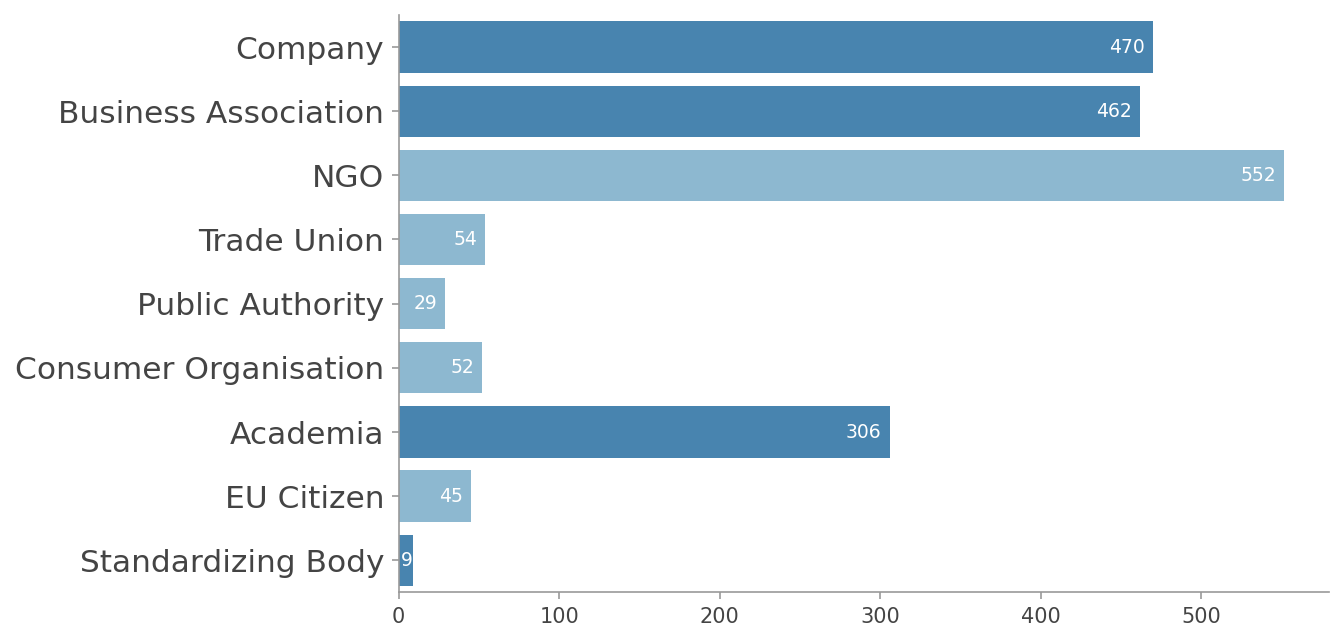

In [35]:
fig, ax = plots.interest_groups_total_pages(n_p)

fig.savefig("figures/dataset_biases_interest_groups_n_pages.pdf", bbox_inches="tight")
shutil.copy(
    "figures/dataset_biases_interest_groups_n_pages.pdf",
    "../../masters_thesis/figures/",
)

##### Comparison with survey

In [36]:
utils.hstack(
    survey["user_type"].value_counts().to_frame("absolute"),
    survey["user_type"].value_counts(normalize=True).to_frame("relative"),
)

,absolute,relative
company,150,0.198413
ngo,117,0.154762
eu_citizen,115,0.152116
academic_research_instittution,112,0.148148
business_association,111,0.146825
other,62,0.082011
public_authority,43,0.056878
trade_union,21,0.027778
non_eu_citizen,17,0.022487
consumer_organisation,7,0.009259


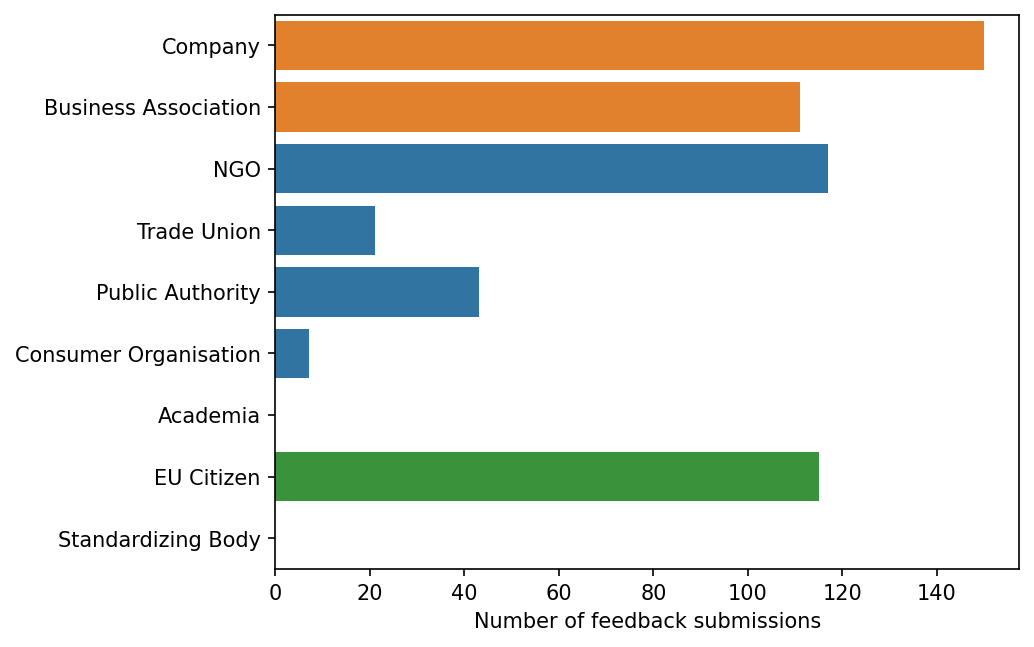

In [37]:
sns.countplot(
    y=survey["user_type"].map(utils.user_type_map),
    order=utils.user_type_order,
    hue=survey["user_type"].map(utils.interest_type_map),
    dodge=False,
)

plt.xlabel("Number of feedback submissions")
plt.ylabel(None)
plt.legend().set_visible(False)
plt.show()

#### Language

##### Share of languages among responses

In [38]:
utils.pprint(
    "Unique languages:",
    feedbacks["language"].unique().shape[0],
    "Fraction English:",
    feedbacks["language"].value_counts(normalize=True).round(2)["en"],
    "Fraction en,fr,de:",
    feedbacks["language"].value_counts(normalize=True)[["en", "de", "fr"]].sum(),
)

Unique languages:      10
Fraction English:    0.870
Fraction en,fr,de:   0.950


In [39]:
print("~ Survey ~")
utils.pprint(
    "Unique languages:",
    survey["language"].unique().shape[0],
    "Fraction English:",
    survey["language"].value_counts(normalize=True)["en"],
    "Fraction en,fr,de:",
    survey["language"].value_counts(normalize=True)[["en", "de", "fr"]].sum(),
)

~ Survey ~
Unique languages:       20
Fraction English:    0.648
Fraction en,fr,de:   0.856


##### Share of English per user type

In [40]:
shares = feedbacks.groupby("interest_type")["language"].value_counts(normalize=True)
shares.to_frame("share").query("language == 'en'")

,,share
interest_type,language,
academia,en,1.000000
citizen,en,0.692308
corporate,en,0.873494
public,en,0.870968
standardizing_body,en,0.666667


In [41]:
shares = feedbacks.groupby("user_type")["language"].value_counts(normalize=True)
shares = shares.to_frame("share").query("language == 'en'")
shares = shares.reset_index(level="language", drop=True).reset_index()
shares["interest_type"] = shares["user_type"].map(utils.interest_type_map)
shares["user_type_name"] = shares["user_type"].map(utils.user_type_map)
shares = shares.sort_values(["interest_type", "share"], ascending=[True, False])
shares[["user_type_name", "share"]]

,user_type_name,share
0,Academia,1.000000
4,EU Citizen,0.692308
2,Company,0.931034
1,Business Association,0.810127
5,NGO,0.920635
3,Consumer Organisation,0.800000
8,Trade Union,0.785714
6,Public Authority,0.727273
7,Standardizing Body,0.666667


In [42]:
df = utils.hstack(
    feedbacks["user_type_name"].value_counts(normalize=True).to_frame("before"),
    feedbacks.query("language == 'en'")["user_type_name"]
    .value_counts(normalize=True)
    .to_frame("after"),
)
df["relative_diff"] = (df["after"] - df["before"]) / df["before"]
df.sort_values("relative_diff")

,before,after,relative_diff
Standardizing Body,0.010033,0.007663,-0.236271
EU Citizen,0.043478,0.034483,-0.206897
Public Authority,0.036789,0.030651,-0.166841
Trade Union,0.046823,0.042146,-0.099891
Consumer Organisation,0.016722,0.015326,-0.083525
Business Association,0.264214,0.245211,-0.071924
NGO,0.210702,0.222222,0.054674
Company,0.290970,0.310345,0.066587
Academia,0.080268,0.091954,0.145594


##### Share of language per country

In [43]:
shares = (
    feedbacks.groupby("country")["language"]
    .value_counts(normalize=True)
    .to_frame("share")
    .query("language == 'en'")
    .reset_index()[["country", "share"]]
)
europe = pd.merge(utils._get_europe(countries), shares)

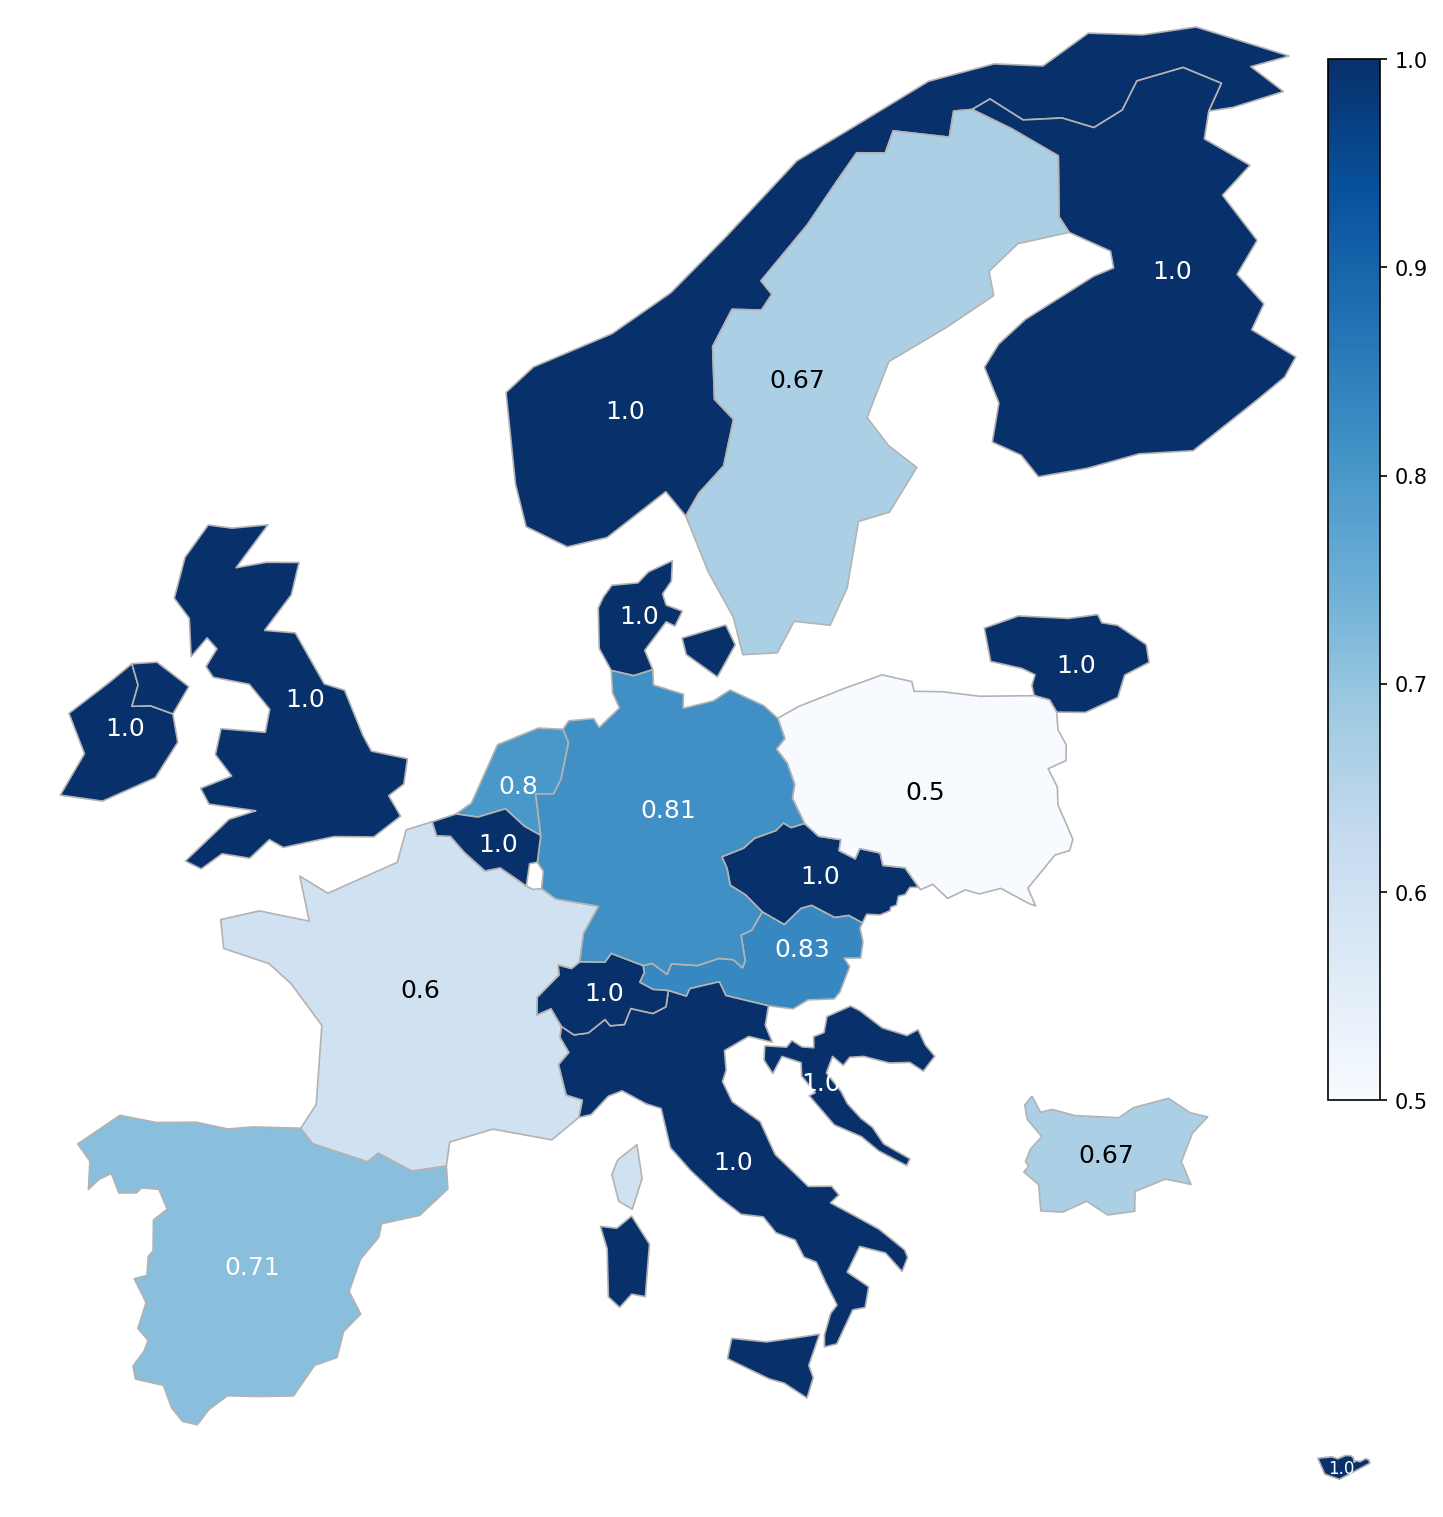

In [44]:
_ = plots.plot_english_usage(europe)

#### Time

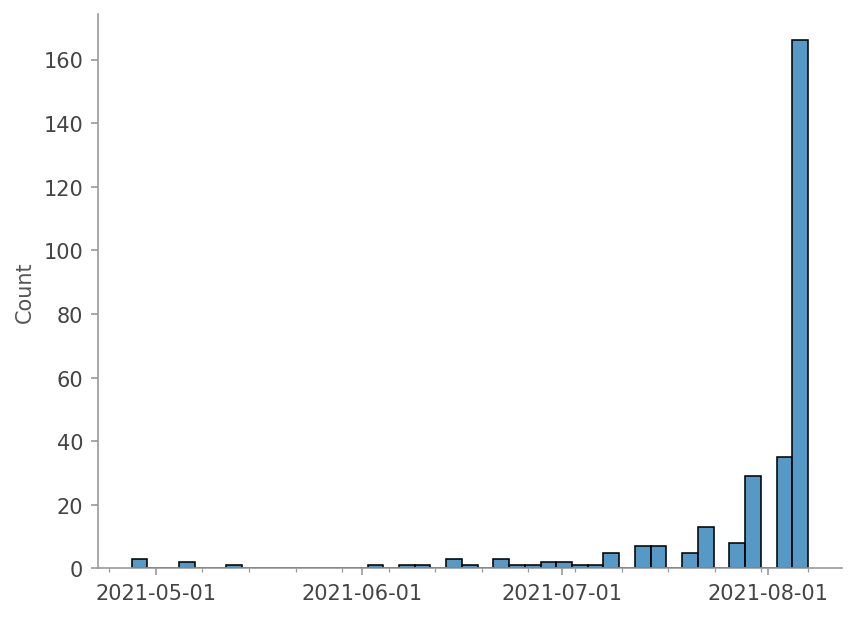

In [45]:
fig, _ = plots.submissions_over_time(feedbacks)
fig.savefig("figures/dataset_biases_time.pdf")

In [46]:
utils.pprint(
    "Last month submissions:",
    (feedbacks["date_feedback"] >= "2021-07-07").mean(),
    "Last  week submissions:",
    (feedbacks["date_feedback"] >= "2021-07-31").mean(),
    "Last   day submissions:",
    (feedbacks["date_feedback"] >= "2021-08-06").mean(),
)

Last month submissions:   0.920
Last  week submissions:   0.672
Last   day submissions:   0.385


In [47]:
utils.pprint(
    "First month submissions:",
    (feedbacks["date_feedback"] <= "2021-05-26").mean(),
    "First  week submissions:",
    (feedbacks["date_feedback"] <= "2021-05-02").mean(),
)

First month submissions:   0.020
First  week submissions:   0.010
